### Homework 4

Import and clean the data.

In [28]:
import time
import numpy as np
import pandas as pd
#Used to split into train and test set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize


#Assumes that the dataset is in the current working directory under the name 'SkyData.csv'
df = pd.read_csv('data/skyserver.csv')

#Delete some irrelevant columns
df.drop(['objid', 'rerun', 'specobjid', 'plate', 'mjd'], axis=1, inplace=True)

#Remove the Quasar class from the dataframe (makes the problem binary classification)
#Change class labels from string to 0 and 1
df = df[df['class']!='QSO']
df['class'] = pd.factorize(df['class'])[0]

#Create a dataframe without the class label
#Convert the dataframe to a numpy array
#Add an extra column of ones to the data so the linear model has an offset
Adf = df.drop('class', axis = 1)
A = Adf.to_numpy()
A = normalize(A)
A = np.hstack((A, np.ones((A.shape[0], 1), dtype=A.dtype)))

#Create a dataframe of only the class labels
#Convert ydf to a numpy array
ydf = df['class']
y = ydf.to_numpy()

#Split data into train and test set
A_train,A_test,y_train,y_test = train_test_split(A, y, test_size=0.2)
print(A_train.shape, A_test.shape, y_train.shape, y_test.shape)

(71535, 13) (17884, 13) (71535,) (17884,)


### Solutions

Implement the following:
1. Standard minibatch stochastic gradient
2. Mini-batch stochastic gradient via random reshuffling
3. SVRG

Begin by defining the L2-regularized logistic regression model.
Given data A and y and regularization parameter mu, compute either the function value or gradient for parameters x.

In [29]:
def logistic_regression_model(x, mode, A, y, mu):
    """
    :param x: input value at which to evaluate function model
    :param A: data feature matrix
    :param y: data labels
    :param mu: L2 regularization parameter
    :return: logistic regression model value or gradient at parameters x
    """

    # compute predicted values for parameters x given data A
    predicted_values = np.matmul(A, x)

    # compute either the function value or gradient of the logistic regression model
    if mode == 'value':
        output = (
            np.mean(
                -1 * y * predicted_values + np.log(1 + np.exp(predicted_values))
            )
            + mu / 2 * np.linalg.norm(x)
        )
    elif mode == 'gradient':
        scalars = (-1 * y + (np.exp(predicted_values) / (1 + np.exp(predicted_values))))
        output = np.matmul(A.T, scalars) / A.shape[0] + mu * x
    else:
        raise ValueError('mode must be either "value" or "gradient"')

    return output


# each epoch consists of a full batch gradient update
def gradient_descent(
    fun,  # objective function
    A_train, A_test, y_train, y_test,  # data
    x0, alpha,  # algorithmic initializations
    total_epochs,
    decay=False  # learning rate decay of form alpha_k = alpha / k
):

    # initialize algorithm at initial point
    x = x0
    alpha_bar = alpha

    gradient_computations = 0
    gradient_computations_all = [gradient_computations]

    training_loss = fun(x, 'value', A_train, y_train)
    testing_loss = fun(x, 'value', A_test, y_test)
    print(f'GD - Epoch 0, Training Loss: {training_loss:.4f}')

    # initialize objects to store output
    training_losses = [training_loss]
    testing_losses = [testing_loss]

    # run until maximum iterations are reached
    for epoch_number in range(total_epochs):
        epoch_start = time.time()

        # compute gradient for all observations
        gradient = fun(
            x, 'gradient',  # compute
            A_train, y_train  # data
        )
        gradient_computations = gradient_computations + 1

        # perform gradient step
        if decay:
            alpha = alpha_bar / (epoch_number + 1)
        x = x - alpha * gradient

        # update training and test losses at batch end
        training_loss = fun(x, 'value', A_train, y_train)
        testing_loss = fun(x, 'value', A_test, y_test)

        # print epoch summary
        epoch_end = time.time()
        if (epoch_number + 1) % 10 == 0:
            print(f'GD - Epoch {epoch_number + 1:d}, Time {epoch_end - epoch_start:.1f}, Training Loss: {training_loss:.4f}')

        # store in output
        gradient_computations_all.append(gradient_computations)
        training_losses.append(training_loss)
        testing_losses.append(testing_loss)


    return np.array(gradient_computations_all), np.array(training_losses), np.array(testing_losses)

The following code chunks implement each of the new algorithmic implementations

In [30]:
# each epoch consists of the number of batches that fit the input data
# each batch is randomly sampled without replacement
def stochastic_gradient_uniformly_at_random(
    fun,  # objective function
    A_train, A_test, y_train, y_test,  # data
    x0, alpha,  # algorithmic initializations
    total_epochs, batch_size,
    decay=False  # learning rate decay of form alpha_k = alpha / k
):

    # initialize algorithm at initial point
    x = x0
    alpha_bar = alpha

    gradient_computations = 0
    gradient_computations_all = [gradient_computations]

    T = 0
    N = A_train.shape[0]
    total_batches = N // batch_size
    print(f'Observations: {N}, Batch Size: {batch_size}, Total Batches: {total_batches}')

    # initialize objects to store output
    training_loss = fun(x, 'value', A_train, y_train)
    testing_loss = fun(x, 'value', A_test, y_test)
    print(f'SGM Uniform - Epoch 0, Training Loss: {training_loss:.4f}')

    training_losses = [training_loss]
    testing_losses = [testing_loss]

    # run until maximum iterations are reached
    for epoch_number in range(total_epochs):
        epoch_start = time.time()

        for batch_number in range(total_batches):

            # select random minibatch of size batch_size
            batch_indices = np.random.randint(
                low=0,
                high=N,
                size=batch_size
            )

            # compute gradient for randomly selected observations
            gradient = fun(
                x, 'gradient',  # compute
                A_train[batch_indices, :], y_train[batch_indices]  # data subset
            )
            gradient_computations = gradient_computations + 1

            # perform gradient step
            # update learning rate
            if decay:
                alpha = alpha_bar / (T + 1)

            x = x - alpha * gradient
            T += 1


        # update training and test losses at batch end
        training_loss = fun(x, 'value', A_train, y_train)
        testing_loss = fun(x, 'value', A_test, y_test)

        # print epoch summary
        epoch_end = time.time()
        if (epoch_number + 1) % 10 == 0:
            print(f'SGM Uniform - Epoch {epoch_number + 1:d}, Time {epoch_end - epoch_start:.1f}, Training Loss: {training_loss:.4f}')

        # store in output
        gradient_computations_all.append(gradient_computations)
        training_losses.append(training_loss)
        testing_losses.append(testing_loss)


    return np.array(gradient_computations_all), np.array(training_losses), np.array(testing_losses)

In [31]:
# each epoch consists of a random permutation of the data set
# batches of size batch_size are processed at a time moving through the permutation
# remaining observations smaller than the desired batch size will be discarded
def stochastic_gradient_random_reshuffle(
    fun,  # objective function
    A_train, A_test, y_train, y_test,  # data
    x0, alpha,  # algorithmic initializations
    total_epochs, batch_size,
    decay=False  # learning rate decay of form alpha_k = alpha / k
):

    # initialize algorithm at initial point
    x = x0
    alpha_bar = alpha

    gradient_computations = 0
    gradient_computations_all = [gradient_computations]

    T = 0
    N = A_train.shape[0]
    total_batches = N // batch_size
    print(f'Observations: {N}, Batch Size: {batch_size}, Total Batches: {total_batches}')

    # initialize objects to store output
    training_loss = fun(x, 'value', A_train, y_train)
    testing_loss = fun(x, 'value', A_test, y_test)
    print(f'SGM Shuffle - Epoch 0, Training Loss: {training_loss:.4f}')

    training_losses = [training_loss]
    testing_losses = [testing_loss]

    # run until maximum iterations are reached
    for epoch_number in range(total_epochs):
        epoch_start = time.time()

        # randomly permute the data at the beginning of each epoch
        # note that data NOT divisible by the batch size will have data discarded
        epoch_permutation = np.random.permutation(N)
        A_train = A_train[epoch_permutation, :]
        y_train = y_train[epoch_permutation]

        for batch_number in range(total_batches):

            # identify the chunk of the permutation to use for this batch
            batch_indices = np.arange(
                start = batch_number * batch_size,
                stop = (batch_number + 1) * batch_size
            )

            # compute gradient for randomly selected observations
            gradient = fun(
                x, 'gradient',  # compute
                A_train[batch_indices, :], y_train[batch_indices]  # data subset
            )
            gradient_computations = gradient_computations + 1

            # update learning rate
            if decay:
                alpha = alpha_bar / (T + 1)

            # perform gradient step
            x = x - alpha * gradient
            T += 1

        # update training and test losses at batch end
        training_loss = fun(x, 'value', A_train, y_train)
        testing_loss = fun(x, 'value', A_test, y_test)

        # print epoch summary
        epoch_end = time.time()
        if (epoch_number + 1) % 10 == 0:
            print(f'SGM Shuffle - Epoch {epoch_number + 1:d}, Time {epoch_end - epoch_start:.1f}, Training Loss: {training_loss:.4f}')

        # store in output
        gradient_computations_all.append(gradient_computations)
        training_losses.append(training_loss)
        testing_losses.append(testing_loss)


    return np.array(gradient_computations_all), np.array(training_losses), np.array(testing_losses)

In [32]:
# source: Alg 5.1 of arxiv.org/pdf/1606.04838.pdf
def stochastic_variance_reduced_gradient(
    fun,  # objective function
    A_train, A_test, y_train, y_test,  # data
    x0, alpha,  # algorithmic initializations
    total_epochs, batch_size  # additional hyperparameters
):
    """
    :param batch_size: used to compute hyperparameter m, will have double the gradient calculation
    """

    # initialize algorithm at initial point
    x_outer, x_inner = x0, x0
    alpha_bar = alpha

    gradient_computations = 0
    gradient_computations_all = []

    # the number of total batches
    N = A_train.shape[0]
    total_batches = N // batch_size
    print(f'Observations: {N}, Batch Size: {batch_size}, Total Batches: {total_batches}')

    # initialize objects to store output
    training_loss = fun(x_outer, 'value', A_train, y_train)
    testing_loss = fun(x_outer, 'value', A_test, y_test)
    print(f'SVRG - Epoch 0, Training Loss: {training_loss:.4f}')

    training_losses = [training_loss]
    testing_losses = [testing_loss]

    # run until maximum iterations are reached
    for epoch_number in range(total_epochs):
        epoch_start = time.time()

        # compute the full batch gradient
        full_gradient = fun(
            x_outer, 'gradient',  # compute
            A_train, y_train  # data
        )
        gradient_computations = gradient_computations + 1

        # inner for loop iterations controlled by hyperparameter m
        for j in range(total_batches):

            # compute gradient for randomly selected observation
            observation_index = np.random.choice(N)

            # with respect to both inner and outer iterations
            outer_gradient = fun(
                x_outer, 'gradient',  # compute
                A_train[[observation_index], :], y_train[observation_index]  # data subset
            )
            gradient_computations = gradient_computations + 1

            inner_gradient = fun(
                x_inner, 'gradient',  # compute
                A_train[[observation_index], :], y_train[observation_index]  # data subset
            )
            gradient_computations = gradient_computations + 1

            # compute gradient estimator
            variance_reduced_gradient = inner_gradient - (outer_gradient - full_gradient)

            # perform gradient step
            x_inner = x_inner - alpha * variance_reduced_gradient


        # update training and test losses at batch end
        x_outer = x_inner
        training_loss = fun(x_outer, 'value', A_train, y_train)
        testing_loss = fun(x_outer, 'value', A_test, y_test)

        epoch_end = time.time()
        if (epoch_number + 1) % 10 == 0:
            print(f'SVRG - Epoch {epoch_number + 1:d}, Time {epoch_end - epoch_start:.1f}, Training Loss: {training_loss:.4f}')

        # store in output
        gradient_computations_all.append(gradient_computations)
        training_losses.append(training_loss)
        testing_losses.append(testing_loss)


    return np.array(gradient_computations_all), np.array(training_losses), np.array(testing_losses)

Perform the various descent methods for 100 total epochs with a batch size of 64 and a small regularization parameter of 10e-3.

In [33]:
# defaults
total_epochs = 100
batch_size = 64
mu = 10e-3

In [34]:
# tune-able hyper-parameters
x0 = np.random.random(size = A_train.shape[-1])
alpha = 0.01

# standard gradient descent
_, gradient_descent_training_losses, gradient_descent_testing_losses = gradient_descent(
    lambda x, y, A, b: logistic_regression_model(x, y, A, b, mu),
    A_train, A_test, y_train, y_test,
    x0, alpha,
    total_epochs
)

methods = ['Fixed GD']
methods_training_losses = [gradient_descent_training_losses]
methods_testing_losses = [gradient_descent_testing_losses]

GD - Epoch 0, Training Loss: 0.7867
GD - Epoch 10, Time 0.0, Training Loss: 0.7790
GD - Epoch 20, Time 0.0, Training Loss: 0.7719
GD - Epoch 30, Time 0.0, Training Loss: 0.7653
GD - Epoch 40, Time 0.0, Training Loss: 0.7592
GD - Epoch 50, Time 0.0, Training Loss: 0.7535
GD - Epoch 60, Time 0.0, Training Loss: 0.7483
GD - Epoch 70, Time 0.0, Training Loss: 0.7434
GD - Epoch 80, Time 0.0, Training Loss: 0.7390
GD - Epoch 90, Time 0.0, Training Loss: 0.7349
GD - Epoch 100, Time 0.0, Training Loss: 0.7311


In [35]:
# stochastic gradient descents
alpha = 0.01
_, uniformly_at_random_training_losses, uniformly_at_random_testing_losses = stochastic_gradient_uniformly_at_random(
    lambda x, y, A, b: logistic_regression_model(x, y, A, b, mu),
    A_train, A_test, y_train, y_test,
    x0, alpha,
    total_epochs, batch_size
)

methods.append('Fixed SGM Uniform')
methods_training_losses.append(uniformly_at_random_training_losses)
methods_testing_losses.append(uniformly_at_random_testing_losses)

Observations: 71535, Batch Size: 64, Total Batches: 1117
SGM Uniform - Epoch 0, Training Loss: 0.7867
SGM Uniform - Epoch 10, Time 0.1, Training Loss: 0.6847
SGM Uniform - Epoch 20, Time 0.1, Training Loss: 0.6832
SGM Uniform - Epoch 30, Time 0.1, Training Loss: 0.6832
SGM Uniform - Epoch 40, Time 0.1, Training Loss: 0.6830
SGM Uniform - Epoch 50, Time 0.1, Training Loss: 0.6830
SGM Uniform - Epoch 60, Time 0.1, Training Loss: 0.6830
SGM Uniform - Epoch 70, Time 0.1, Training Loss: 0.6830
SGM Uniform - Epoch 80, Time 0.1, Training Loss: 0.6830
SGM Uniform - Epoch 90, Time 0.1, Training Loss: 0.6830
SGM Uniform - Epoch 100, Time 0.1, Training Loss: 0.6830


In [36]:
alpha = 0.5
_, uniformly_at_random_decay_training_losses, uniformly_at_random_decay_testing_losses = stochastic_gradient_uniformly_at_random(
    lambda x, y, A, b: logistic_regression_model(x, y, A, b, mu),
    A_train, A_test, y_train, y_test,
    x0, alpha,
    total_epochs, batch_size,
    decay=True
)

methods.append('Decay SGM Uniform')
methods_training_losses.append(uniformly_at_random_decay_training_losses)
methods_testing_losses.append(uniformly_at_random_decay_testing_losses)

Observations: 71535, Batch Size: 64, Total Batches: 1117
SGM Uniform - Epoch 0, Training Loss: 0.7867
SGM Uniform - Epoch 10, Time 0.1, Training Loss: 0.6914
SGM Uniform - Epoch 20, Time 0.1, Training Loss: 0.6912
SGM Uniform - Epoch 30, Time 0.1, Training Loss: 0.6911
SGM Uniform - Epoch 40, Time 0.1, Training Loss: 0.6910
SGM Uniform - Epoch 50, Time 0.1, Training Loss: 0.6910
SGM Uniform - Epoch 60, Time 0.1, Training Loss: 0.6909
SGM Uniform - Epoch 70, Time 0.1, Training Loss: 0.6909
SGM Uniform - Epoch 80, Time 0.1, Training Loss: 0.6909
SGM Uniform - Epoch 90, Time 0.1, Training Loss: 0.6909
SGM Uniform - Epoch 100, Time 0.1, Training Loss: 0.6909


In [37]:
alpha = 0.01
_, random_reshuffle_training_losses, random_reshuffle_testing_losses = stochastic_gradient_random_reshuffle(
    lambda x, y, A, b: logistic_regression_model(x, y, A, b, mu),
    A_train, A_test, y_train, y_test,
    x0, alpha,
    total_epochs, batch_size
)

methods.append('Fixed SGM Shuffle')
methods_training_losses.append(random_reshuffle_training_losses)
methods_testing_losses.append(random_reshuffle_testing_losses)

Observations: 71535, Batch Size: 64, Total Batches: 1117
SGM Shuffle - Epoch 0, Training Loss: 0.7867
SGM Shuffle - Epoch 10, Time 0.1, Training Loss: 0.6847
SGM Shuffle - Epoch 20, Time 0.1, Training Loss: 0.6832
SGM Shuffle - Epoch 30, Time 0.1, Training Loss: 0.6830
SGM Shuffle - Epoch 40, Time 0.1, Training Loss: 0.6830
SGM Shuffle - Epoch 50, Time 0.1, Training Loss: 0.6830
SGM Shuffle - Epoch 60, Time 0.1, Training Loss: 0.6830
SGM Shuffle - Epoch 70, Time 0.1, Training Loss: 0.6830
SGM Shuffle - Epoch 80, Time 0.1, Training Loss: 0.6830
SGM Shuffle - Epoch 90, Time 0.0, Training Loss: 0.6830
SGM Shuffle - Epoch 100, Time 0.1, Training Loss: 0.6830


In [38]:
alpha = 0.5
_, random_reshuffle_decay_training_losses, random_reshuffle_decay_testing_losses = stochastic_gradient_random_reshuffle(
    lambda x, y, A, b: logistic_regression_model(x, y, A, b, mu),
    A_train, A_test, y_train, y_test,
    x0, alpha,
    total_epochs, batch_size,
    decay=True
)

methods.append('Decay SGM Shuffle')
methods_training_losses.append(random_reshuffle_decay_training_losses)
methods_testing_losses.append(random_reshuffle_decay_testing_losses)

Observations: 71535, Batch Size: 64, Total Batches: 1117
SGM Shuffle - Epoch 0, Training Loss: 0.7867
SGM Shuffle - Epoch 10, Time 0.1, Training Loss: 0.6916
SGM Shuffle - Epoch 20, Time 0.1, Training Loss: 0.6913
SGM Shuffle - Epoch 30, Time 0.1, Training Loss: 0.6912
SGM Shuffle - Epoch 40, Time 0.1, Training Loss: 0.6911
SGM Shuffle - Epoch 50, Time 0.0, Training Loss: 0.6911
SGM Shuffle - Epoch 60, Time 0.1, Training Loss: 0.6910
SGM Shuffle - Epoch 70, Time 0.0, Training Loss: 0.6910
SGM Shuffle - Epoch 80, Time 0.1, Training Loss: 0.6910
SGM Shuffle - Epoch 90, Time 0.1, Training Loss: 0.6910
SGM Shuffle - Epoch 100, Time 0.1, Training Loss: 0.6909


In [39]:
import math

# variance reduced gradient estimation algorithm
alpha = 0.01
_, variance_reduced_training_losses, variance_reduced_testing_losses = stochastic_variance_reduced_gradient(
    lambda x, y, A, b: logistic_regression_model(x, y, A, b, mu),
    A_train, A_test, y_train, y_test,
    x0, alpha,
    math.ceil(total_epochs / 2),
    batch_size=1
)

Observations: 71535, Batch Size: 1, Total Batches: 71535
SVRG - Epoch 0, Training Loss: 0.7867
SVRG - Epoch 10, Time 4.1, Training Loss: 0.6830
SVRG - Epoch 20, Time 4.4, Training Loss: 0.6830
SVRG - Epoch 30, Time 4.0, Training Loss: 0.6830
SVRG - Epoch 40, Time 4.0, Training Loss: 0.6830
SVRG - Epoch 50, Time 3.9, Training Loss: 0.6830


Plot the various training and testing losses on seperate plots

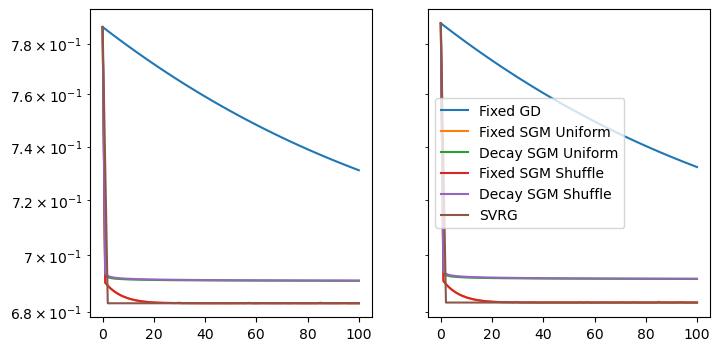

In [41]:
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))

# plot training losses
plt.sca(axarr[0])
for method_training_losses in methods_training_losses:
    plt.plot(np.arange(len(method_training_losses)), method_training_losses)
plt.plot(2 * np.arange(len(variance_reduced_training_losses)), variance_reduced_training_losses)

# plot testing losses
plt.sca(axarr[1])
for method_testing_losses in methods_testing_losses:
    plt.plot(np.arange(len(method_testing_losses)), method_testing_losses)
plt.semilogy(2 * np.arange(len(variance_reduced_testing_losses)), variance_reduced_testing_losses)

plt.legend(methods + ['SVRG'])
plt.show()


A few comments on the above image:
- Both decaying SGM methods converge to a higher value than optimal. Note than since the decaying learning rate is a function of the number of iterations, a large learning rate may be required to reach the optimal solution.
- Gradient descent appears relatively slow compared to the other methods. However, the alternative methods take over 1000 updates with the given batch size for each update of gradient descent. Even though the data passes are equivalent, perhaps the work done is not a perfectly fair comparison.